In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from imblearn.over_sampling import ADASYN

/var/folders/8t/jw61zz954rbcbps32kpn49l80000gn/T/ipykernel_42804/2503002809.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('../dataset_tables/final_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      251 non-null    object
 1   split   251 non-null    object
 2   Label   251 non-null    bool  
 3   NDVI    251 non-null    object
 4   NBR     251 non-null    object
 5   NDWI    251 non-null    object
 6   NDBI    251 non-null    object
 7   RGB     251 non-null    object
dtypes: bool(1), object(7)
memory usage: 14.1+ KB


In [4]:
# Function to convert string to list
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

# Apply conversion function to relevant columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))

X = np.array([np.ravel(ndvi + ndwi + ndbi)
        for ndvi, ndwi, ndbi in zip(data['NDVI'], data['NDWI'], data['NDBI'])])

y = np.array(data['Label'])

In [5]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define parameter grid for SVM
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

In [8]:
# Perform grid search with cross-validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))


The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.84


In [9]:
# Initialize SVM model with best parameters
best_params = grid.best_params_
model = svm.SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C']).fit(X_train, y_train)

In [10]:
# Evaluate model on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7882
Precision: 0.7500
Recall: 0.8864
F1-score: 0.8125

Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.68      0.76        41
        True       0.75      0.89      0.81        44

    accuracy                           0.79        85
   macro avg       0.80      0.78      0.78        85
weighted avg       0.80      0.79      0.79        85


Confusion Matrix:
[[28 13]
 [ 5 39]]


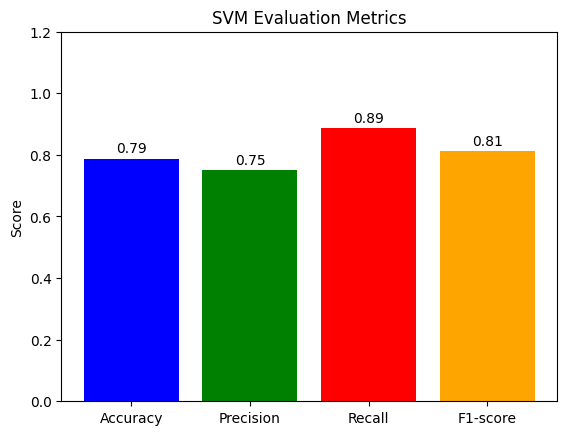

In [11]:
# Visualize model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('SVM Evaluation Metrics')
plt.ylim(0, 1.2)
plt.show()